<h1>Text Analytics</h1>

In [1]:
%pylab inline 
import nltk
import ujson
import re
import time
import progressbar

import pandas as pd
from __future__ import print_function
from six.moves import zip, range 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import PorterStemmer

nltk.download('stopwords') #download the latest stopwords

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to /Users/Amit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h2>Load the Data</h2>

In [88]:
df_jobs_data = pd.read_csv('jobs_subset.csv')

<h2>Explore the Data</h2>

In [89]:
df_jobs_data.head()

,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title
0,Lawyers,23-1011.00,This position is in support of the United Stat...,"Paralegal (Buffalo, NY)"
1,Software Quality Assurance Engineers and Testers,15-1199.01,The successful candidate will maintain and dev...,System Integration / Test Engineer
2,Software Quality Assurance Engineers and Testers,15-1199.01,This position is a Senior System Integration &...,System Integration / Test Engineer Staff
3,Software Quality Assurance Engineers and Testers,15-1199.01,"In this position, candidates may participate i...",Mult Func Fin Analyst
4,Software Quality Assurance Engineers and Testers,15-1199.01,This is a business operations analyst position...,Mult Func Fin Analyst


In [90]:
df_jobs_data.normalizedTitle_onetName.unique()

array(['Lawyers', 'Software Quality Assurance Engineers and Testers',
       'Graduate Teaching Assistants', 'Financial Examiners',
       'Credit Analysts'], dtype=object)

In [91]:
df_jobs_data.title.unique()

array(['Paralegal (Buffalo, NY)', 'System Integration / Test Engineer',
       'System Integration / Test Engineer Staff', ...,
       'JAVA ENGINEER(perm)', 'BSA Analyst', 'AML/KYC Analyst'], dtype=object)

In [92]:
df_jobs_data.title.unique().shape

(2496,)

<h2>Topic Modeling</h2>

In [93]:
def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                        stem = False,
                       MIN_DF = 0.05,
                       MAX_DF = 0.95,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tupule
        range of N-gram default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
     
    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

<h3>Processing text data</h3>

In [94]:
toy_corpus = ['this is document one', 'this is document two', 'text analysis on documents is fun']
toy_bag_of_words, toy_features = create_bag_of_words(toy_corpus)
toy_corpus

['this is document one',
 'this is document two',
 'text analysis on documents is fun']

In [95]:
np_bag_of_words = toy_bag_of_words.toarray()
np_bag_of_words

array([[0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0, 0]], dtype=int64)

In [96]:
toy_features

['analysis',
 'document',
 'documents',
 'fun',
 'on',
 'one',
 'text',
 'this',
 'two']

In [97]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [98]:
get_word_counts(toy_bag_of_words, toy_features)

OrderedDict([('document', 2),
             ('this', 2),
             ('analysis', 1),
             ('documents', 1),
             ('fun', 1),
             ('on', 1),
             ('one', 1),
             ('text', 1),
             ('two', 1)])

<h3>Text Corpora</h3>

In [99]:
corpus = df_jobs_data['jobDescription'].values #pull all the jobDescriptions and put them in a numpy array 
corpus

array([ "This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final di

In [100]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic

In [101]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus)

In [102]:
corpus_features

['00',
 '000',
 '10',
 '100',
 '11',
 '12',
 '15',
 '20',
 '2015',
 '25',
 '30',
 '40',
 '50',
 '500',
 '80',
 '800',
 'aa',
 'abilities',
 'ability',
 'able',
 'about',
 'above',
 'academic',
 'access',
 'accordance',
 'according',
 'accounting',
 'accounts',
 'accredited',
 'accuracy',
 'accurate',
 'achieve',
 'across',
 'act',
 'action',
 'active',
 'activities',
 'addition',
 'additional',
 'administration',
 'administrative',
 'admired',
 'advance',
 'advanced',
 'affirmative',
 'again',
 'against',
 'age',
 'agencies',
 'agency',
 'agile',
 'agreeing',
 'al',
 'all',
 'along',
 'also',
 'an',
 'analysis',
 'analyst',
 'analytical',
 'analyze',
 'and',
 'anos',
 'any',
 'applicable',
 'applicants',
 'application',
 'applications',
 'apply',
 'applying',
 'appropriate',
 'architecture',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'aspects',
 'assessment',
 'assigned',
 'assist',
 'assistance',
 'assistant',
 'assisting',
 'assists',
 'associate',
 'associated',
 'assurance',
 'a

In [103]:
get_word_counts(corpus_bag_of_words, corpus_features)

OrderedDict([('and', 72036),
             ('to', 36758),
             ('the', 34940),
             ('of', 31793),
             ('in', 23879),
             ('with', 16877),
             ('for', 15605),
             ('or', 13556),
             ('experience', 11108),
             ('is', 10153),
             ('de', 8563),
             ('as', 8252),
             ('be', 7101),
             ('on', 7003),
             ('work', 6583),
             ('our', 6556),
             ('will', 5949),
             ('are', 5769),
             ('an', 5686),
             ('job', 5631),
             ('software', 5360),
             ('skills', 5337),
             ('we', 5198),
             ('development', 5079),
             ('you', 4884),
             ('test', 4744),
             ('this', 4584),
             ('team', 4450),
             ('all', 4442),
             ('that', 4267),
             ('ability', 4248),
             ('other', 4207),
             ('required', 4147),
             ('business', 4010),
   

In [104]:
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features)

| 2 Elapsed Time: 0:00:33                                                      


0 de, en, la, con, el
1 and, to, the, of, in
2 and, to, the, of, in


<h3>Text Cleaning and Normalization</h3>

In [105]:
RE_PREPROCESS = r'\W+|\d+'
processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )
corpus[0]

"This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final dispositio

In [106]:
processed_corpus[0]

'this position is in support of the united states attorney s office in buffalo ny located at   delaware avenue the estimated length of this assignment is through may     with the possibility of extensions overtime and travel may be authorized as needed the employee will perform the following tasks but not limited to serves as a primary resource for the office on all aspects of docketing recommends revisions in office procedures to improve the docketing function by expediting case processing changing codes for data elements etc reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system advises other personnel on appropriate codes for unprecedented cases explains the operation of the system and importance of timely information to new attorneys and support staff responsibility for developing maintaining automated records for the criminal and civil case workload from initial referral to final disposition regularly inputs new i

<h3>Tokenization</h3>

In [107]:
tokens = processed_corpus[0].split()
tokens

['this',
 'position',
 'is',
 'in',
 'support',
 'of',
 'the',
 'united',
 'states',
 'attorney',
 's',
 'office',
 'in',
 'buffalo',
 'ny',
 'located',
 'at',
 'delaware',
 'avenue',
 'the',
 'estimated',
 'length',
 'of',
 'this',
 'assignment',
 'is',
 'through',
 'may',
 'with',
 'the',
 'possibility',
 'of',
 'extensions',
 'overtime',
 'and',
 'travel',
 'may',
 'be',
 'authorized',
 'as',
 'needed',
 'the',
 'employee',
 'will',
 'perform',
 'the',
 'following',
 'tasks',
 'but',
 'not',
 'limited',
 'to',
 'serves',
 'as',
 'a',
 'primary',
 'resource',
 'for',
 'the',
 'office',
 'on',
 'all',
 'aspects',
 'of',
 'docketing',
 'recommends',
 'revisions',
 'in',
 'office',
 'procedures',
 'to',
 'improve',
 'the',
 'docketing',
 'function',
 'by',
 'expediting',
 'case',
 'processing',
 'changing',
 'codes',
 'for',
 'data',
 'elements',
 'etc',
 'reviews',
 'reports',
 'to',
 'identify',
 'recurring',
 'errors',
 'and',
 'trains',
 'new',
 'employees',
 'in',
 'the',
 'operati

<h3>Stopwords</h3>

In [108]:
eng_stopwords =  stopwords.words('english')
#sample of stopwords
eng_stopwords[::10]

['i',
 'yours',
 'herself',
 'which',
 'was',
 'does',
 'because',
 'against',
 'from',
 'further',
 'any',
 'nor',
 't',
 'o',
 'hasn',
 'weren']

In [109]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,stop_words=eng_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

OrderedDict([('experience', 11108),
             ('de', 8575),
             ('work', 6583),
             ('job', 5631),
             ('software', 5360),
             ('skills', 5337),
             ('development', 5079),
             ('test', 4744),
             ('team', 4450),
             ('ability', 4248),
             ('required', 4147),
             ('business', 4010),
             ('quality', 3664),
             ('requirements', 3653),
             ('position', 3494),
             ('testing', 3413),
             ('knowledge', 3366),
             ('years', 3336),
             ('management', 3320),
             ('must', 3261),
             ('systems', 3103),
             ('engineering', 3047),
             ('services', 3043),
             ('information', 2989),
             ('support', 2955),
             ('legal', 2816),
             ('en', 2791),
             ('status', 2757),
             ('opportunity', 2734),
             ('including', 2627),
             ('working', 2559),
   

In [110]:
top_20_words = list(dict_processed_word_counts.keys())[:20]
domain_specific_stopwords = eng_stopwords + top_20_words
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

OrderedDict([('systems', 3103),
             ('engineering', 3047),
             ('services', 3043),
             ('information', 2989),
             ('support', 2955),
             ('legal', 2816),
             ('en', 2791),
             ('status', 2757),
             ('opportunity', 2734),
             ('including', 2627),
             ('working', 2559),
             ('design', 2531),
             ('company', 2528),
             ('technical', 2487),
             ('data', 2359),
             ('provide', 2307),
             ('time', 2297),
             ('degree', 2276),
             ('related', 2264),
             ('new', 2242),
             ('strong', 2206),
             ('environment', 2105),
             ('qualifications', 2103),
             ('system', 2072),
             ('compliance', 2019),
             ('equal', 1993),
             ('preferred', 1925),
             ('location', 1899),
             ('training', 1839),
             ('employer', 1799),
             ('product', 179

In [111]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features)

| 2 Elapsed Time: 0:00:20                                                      


0 medical, time, apply, training, provide
1 en, legal, la, compliance, con
2 systems, engineering, design, status, technical


In [112]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 5,
                                                      N_TOP_WORDS= 10)

| 4 Elapsed Time: 0:00:24                                                      


0 status, information, systems, employment, equal, opportunity, system, engineering, national, qualifications
1 legal, robert, half, apply, compensation, law, applicants, professionals, companies, applying
2 en, la, laboratory, care, con, el, experiencia, medical, clinical, patient
3 design, engineering, technical, systems, engineer, data, tools, solutions, product, services
4 compliance, including, support, company, risk, provide, related, strong, financial, credit


In [113]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

| 9 Elapsed Time: 0:00:24                                                      


0 medical, laboratory, health, care, hours, services, clinical, patient, time, assistant, lab, department, training, service, state
1 web, tools, automation, technical, integration, java, project, systems, automated, qa, applications, security, cases, agile, sql
2 procedures, process, related, perform, ensure, reports, processes, duties, support, technical, activities, including, project, documentation, data
3 status, systems, national, protected, gender, disability, race, origin, religion, color, veteran, sexual, equal, opportunity, orientation
4 design, engineering, new, engineer, data, product, solutions, technologies, systems, products, computer, working, technical, services, strong
5 sales, us, partner, career, customer, program, marketing, customers, people, life, personal, drive, develop, company, insurance
6 compliance, financial, credit, regulatory, strong, including, risk, corporate, finance, support, issues, internal, analyst, services, accounting
7 legal, law, half, counsel

<h3>Stemming and lemmitzation</h3>

In [114]:
stemmer = PorterStemmer()
print(stemmer.stem('lies'))
print(stemmer.stem("lying"))
print(stemmer.stem('systematic'))
print(stemmer.stem("running"))

lie
lie
systemat
run


In [119]:
dict_word_counts = get_word_counts(processed_bag_of_words,
                   processed_features)
dict_word_counts

OrderedDict([('systems', 3103),
             ('engineering', 3047),
             ('services', 3043),
             ('information', 2989),
             ('support', 2955),
             ('legal', 2816),
             ('en', 2791),
             ('status', 2757),
             ('opportunity', 2734),
             ('including', 2627),
             ('working', 2559),
             ('design', 2531),
             ('company', 2528),
             ('technical', 2487),
             ('data', 2359),
             ('provide', 2307),
             ('time', 2297),
             ('degree', 2276),
             ('related', 2264),
             ('new', 2242),
             ('strong', 2206),
             ('environment', 2105),
             ('qualifications', 2103),
             ('system', 2072),
             ('compliance', 2019),
             ('equal', 1993),
             ('preferred', 1925),
             ('location', 1899),
             ('training', 1839),
             ('employer', 1799),
             ('product', 179

In [120]:
#grab the topic_id of the majority topic for each document and store it in a list
ls_topic_id = [np.argsort(processed_doctopic[comment_id])[::-1][0] for comment_id in range(len(corpus))]
df_jobs_data['topic_id'] = ls_topic_id 

In [121]:
topic_num = 0
print(processed_keywords[topic_num])
df_jobs_data[ df_jobs_data.topic_id == topic_num ].head(10)

medical, laboratory, health, care, hours, services, clinical, patient, time, assistant, lab, department, training, service, state


,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title,topic_id
16,Graduate Teaching Assistants,25-1191.00,Lab Assistant Category: Clinical Services/Diag...,Lab Assistant,0
17,Graduate Teaching Assistants,25-1191.00,Lab Assistant Category: Clinical Services/Diag...,Lab Assistant,0
18,Graduate Teaching Assistants,25-1191.00,Lab Assistant Category: Clinical Services/Diag...,Lab Assistant,0
19,Graduate Teaching Assistants,25-1191.00,Lab Assistant Category: Clinical Services/Diag...,Lab Assistant,0
20,Graduate Teaching Assistants,25-1191.00,Lab Assistant Category: Clinical Services/Diag...,Lab Assistant,0
21,Graduate Teaching Assistants,25-1191.00,"****This position is an ""alternate"" position. ...",Laboratory Assistant (Alternate position),0
66,Financial Examiners,13-2061.00,"Job Title: COMPLIANCE EXAMINER 1, 2 Agency: GO...","COMPLIANCE EXAMINER 1, 2",0
67,Financial Examiners,13-2061.00,"Job Title: Compliance Examiner 1, 2, or 3 Agen...","Compliance Examiner 1, 2, or 3",0
68,Software Quality Assurance Engineers and Testers,15-1199.01,Job Title: ENGINEER 4 Agency: DOTD-Engineering...,ENGINEER 4,0
69,Software Quality Assurance Engineers and Testers,15-1199.01,Job Title: CORRECTIONS CADET TEST Agency: DOC ...,CORRECTIONS CADET TEST,0


<h1>Supervised Learning: Document Classification</h1>

In this part, you will adapt the classifier in the previous tutorial to use learned document vectors instead of tfidf scores.
<h2>Load our Data</h2>

In [3]:
df_train = pd.read_csv('train_corpus_document_tagging.csv')
df_test = pd.read_csv('test_corpus_document_tagging.csv')

In [4]:
df_train.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,96011,Credit Analysts,/Join a financial group thats as committed to ...
1,355594,Credit Analysts,"for fastest consideration on this position, pl..."
2,118598,Credit Analysts,As a Credit Analyst youll be responsible for c...
3,107794,Credit Analysts,We are a specialty retailer offering the very ...
4,40010,Credit Analysts,Title: KYC Remediation Team Analyst II Locatio...


In [5]:
df_train['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [6]:
Counter(df_train['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 51, 'Financial Examiners': 51})

In [7]:
df_test.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,356466,Credit Analysts,Collections Analyst to monitor and follow up o...
1,314705,Credit Analysts,"Credit Analyst **Location:** LAVERGNE, TN **Sa..."
2,84895,Credit Analysts,Deputy Head of Credit/Senior Credit Officer - ...
3,194749,Credit Analysts,Dresden Partners cuenta con 10 anos de experie...
4,351689,Credit Analysts,Degreed accountant with manufacturing experien...


In [8]:
df_test['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [9]:
Counter(df_test['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 77, 'Financial Examiners': 77})

<h2>Process our Data</h2>

In [14]:
RE_PREPROCESS = r'\W+|\d+'
train_labels = df_train.normalizedTitle_onetName.values
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])
test_labels = df_test.normalizedTitle_onetName.values
test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])
labels = np.append(train_labels, test_labels)

<h2>Apply the Doc2Vec Model</h2>

In [41]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

class LabeledLineSentence(object):
    def __init__(self, doc_list, label_list):
        self.doc_list = doc_list
        self.label_list = label_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(), tags=[self.label_list[idx]])
    def to_array(self):
        self.sentences = []
        for idx, doc in enumerate(self.doc_list):
            self.sentences.append(LabeledSentence(words=doc.split(), tags=[self.label_list[idx]]))
        return self.sentences

In [42]:
sentences = LabeledLineSentence(train_corpus, train_labels)
sentences

<h3>Train the Model</h3>

In [43]:
model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
model.build_vocab(sentences)

for epoch in range(10):
    model.train(sentences,total_examples=model.corpus_count,epochs=model.iter)
    model.alpha -= 0.002 # decrease the learning rate`
    model.min_alpha = model.alpha # fix the learning rate, no decay

model.save("my_model.doc2vec")
model_loaded = models.Doc2Vec.load('my_model.doc2vec')


In [44]:
model.most_similar('good')

[('character', 0.6925367116928101),
 ('conceptual', 0.6718416213989258),
 ('principles', 0.6701986789703369),
 ('perception', 0.6636039018630981),
 ('displaying', 0.6631690859794617),
 ('demonstrates', 0.663133978843689),
 ('diagnostic', 0.660804271697998),
 ('exercises', 0.6605523824691772),
 ('macros', 0.6504859924316406),
 ('formulas', 0.6474169492721558)]

<h3>Test the Model</h3>

In [46]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)

train_size = df_train.shape[0]
train_set_idx = np.arange(0,train_size)
test_set_idx = np.arange(train_size, len(labels))
train_labels_binary = labels_binary[train_set_idx]
test_labels_binary = labels_binary[test_set_idx]

In [50]:
model.infer_vector(['I', 'feel', 'sad'])

array([ 0.01817829, -0.04513381, -0.00834776, -0.04316266, -0.03267238,
       -0.01365315, -0.01135784, -0.01846138, -0.0355072 , -0.01867893,
       -0.02876122, -0.03047338,  0.0129367 , -0.03319901, -0.03980731,
        0.0053178 , -0.00386951, -0.02155838, -0.00567445, -0.04759717,
       -0.04606895, -0.02277746,  0.06693771,  0.04197951,  0.00028403,
        0.0011993 , -0.00220123, -0.04029179, -0.00013771, -0.00890119,
       -0.00546473,  0.00995721,  0.02836243, -0.00772298, -0.00309724,
       -0.02855158,  0.06307336,  0.0174746 ,  0.01942543, -0.06120516,
        0.00543472, -0.04766133, -0.02350466, -0.00280829,  0.01537882,
        0.06190081,  0.00299726,  0.02051618, -0.05549207, -0.00856692,
        0.00239814,  0.00171133, -0.00515643,  0.00945539,  0.00916387,
        0.03225711, -0.04443426, -0.00373947,  0.00840397, -0.01268442,
       -0.01592319, -0.00546471,  0.00030666,  0.01470044, -0.00328677,
        0.0042765 , -0.00614345,  0.01513559, -0.02972334,  0.07

In [51]:
X = []
for i in range(len(train_corpus)):
    X.append(model.infer_vector(train_corpus[i]))
train_x = np.asarray(X)
train_x.shape


(102, 100)

In [52]:
Y = np.asarray(train_labels)
le = preprocessing.LabelEncoder()
le.fit(Y)
train_y = le.transform(Y)
np.mean(train_y)

0.5

In [53]:
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Credit Analysts' 51]
 ['Financial Examiners' 51]]


<h2>Use Logistic Regression as Classifier</h2>

In [55]:
logreg = LogisticRegression(penalty='l1')
logreg.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [56]:
test_list = []
for i in range(len(test_corpus)):
    test_list.append(model.infer_vector(test_corpus[i]))
test_x = np.asarray(test_list)
test_Y = np.asarray(test_labels)
test_y = le.transform(test_Y)

<h2>Evaluation</h2>

In [118]:
preds = logreg.predict(test_x)
np.mean(test_y)
sum(preds == test_y) / len(test_y)

0.57792207792207795

According to the result, our model has 57.8% accuracy.

In [85]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.718179


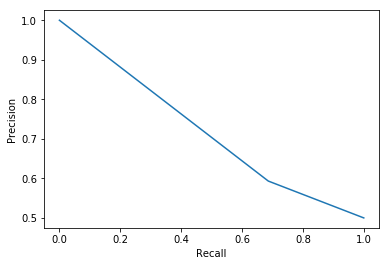

In [86]:
plot_precision_recall(train_y,preds)

The area under the curve is 0.72, so we see a good classifier. The AUC shows how accurate our scores are under different cut-off thresholds. The closer our scores are to the true values the more resilent they are to different cutoffs. For instance, if our scores were perfect our AUC would be 1.